<a href="https://colab.research.google.com/github/catastropiyush/machine-learning-and-simulation/blob/main/poisson_pinn_in_jax_equinox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks (PINNs) in JAX

Simple example of training a PINN in JAX using the Equinox deep learning framework to solve the 1D Poisson equation with homogeneous Dirichlet boundary conditions on the unit interval.

$$
\begin{align}
    \frac{\partial^2 u}{\partial x^2} &= - f(x), \quad x \in (0, 1) \\
    u(0) &= u(1) = 0
\end{align}
$$

### What are PINNs and how to train them?

A PINN is a **coordinate network** that attempts to approximate the solution to a partial differential equation $\hat{u}_\theta(t, x) \approx u(t, x)$. The network is trained to minimize the residuum of the partial differential equation, the boundary conditions, and the initial conditions (if applicable, here we just have a stationary problem). Hence, it can be data-free; additional supervised reference information is optional. Derivative information is obtained via higher-order input-output automatic differentiation of the neural network.

The typical architecture for PINNs are Multi-Layer Perceptrons whose inputs are the position in space $x$ (can be higher dimensional) and time $t$ (if applicable). The output of the network is the solution $\hat{u}_\theta(t, x)$ at the given position and time.

In our case, the parameters are found by minimizing the following composite loss

$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta) = \arg\min_\theta \left( \mathcal{L}_\text{PDE}(\theta) + \mathcal{L}_\text{BC}(\theta) \right)
$$

with the PDE residuum given as the **mean squared error of the residual at randomly sampled collocation points inside the domain**

$$
\mathcal{L}_\text{PDE}(\theta) = \frac{1}{2L} \sum_{i=1}^{L} \left( \frac{\partial^2 \hat{u}_\theta}{\partial x^2}\bigg|_{x=x^{[i]}} + f(x^{[i]}) \right)^2
\qquad \text{with} \qquad
x^{[i]} \sim \mathcal{U}(0, 1)
$$

and the boundary conditions given as the **mean squared error of the solution at randomly sampled boundary points** (here we can just use the left and right boundary points)

$$
\mathcal{L}_\text{BC}(\theta) = \frac{1}{2} \left( \hat{u}_\theta(0) - 0 \right)^2 + \frac{1}{2} \left( \hat{u}_\theta(1) - 0 \right)^2
$$

### The part with automatic differentiation

The idea of PINNs goes back to works in 90s, but experiences a renaissance due to easily available higher-order autodiff engines in deep learning frameworks.

In order to train PINNs to solve PDEs with the highest derivative order being $k$, we need $k+1$ autodiff passes because after the assembly of the loss function, gradient information needs to be backpropagated into the parameter space of the network. We need this information to update the parameters via gradient-based optimizers (like ADAM). In other words, we use the AD engine to then produce $\frac{\partial \mathcal{L}}{\partial \theta}$.

### A reference solution by Finite Differences

To check whether the network a learned meaningful solution to the PDE, we use a three-point stencil reference solution.

1. Discretize the unit intervale domain into $N+2$ points, but only consider $N$ interior points.
2. Solve the linear system of equations $A u = b$ with $A \in \mathbb{R}^{N \times N}$ and $b \in \mathbb{R}^N$ with
    1. $A$ being due to the three point-stencil (tri-diagonal matrix with $1$ on the off-diagonals and $-2$ on the diagonal, scaled by $\frac{1}{(\Delta x)^2}$)
    2. $b$ being the right-hand side of the PDE evaluated at the interior points, i.e., $b_i = - f(x_i)$
3. Sandwich the boundary conditions to the solution vector $u$ and plot the solution.

### The concrete scenario

We consider a discontinuous right-hand side

$$
f(x) = \begin{cases}
    1 & \text{if } x > 0.3 \land x < 0.5 \\
    0 & \text{otherwise}
\end{cases}

# Changes in comparison to the YouTube video:

1. Use correct `init_key` for initializing the neural network
2. Change `N_OPTIMIZATION_EPOCHS` to `10_000`

In [2]:
!pip install equinox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [18]:
!pip install smplotlib
import smplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 5.5 MB/s eta 0:00:00


In [3]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [4]:
N_DOF_FD = 100
N_COLLOCATION_POINTS = 50
LEARNING_RATE = 1e-3
N_OPTIMIZATION_EPOCHS = 10_000
BC_LOSS_WEIGHT = 100.0

In [5]:
# Reproducibility
key = jr.PRNGKey(42)

In [6]:
# Our PINN is a coordinate network in the form of a MLP, mapping from scalar to scalar values
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size="scalar",
    out_size="scalar",
    width_size=10,
    depth=4,
    activation=jax.nn.sigmoid,
    key=init_key,
)

In [8]:
pinn(0.2)

Array(-0.68502796, dtype=float32)

In [9]:
mesh_full = jnp.linspace(0.0, 1.0, N_DOF_FD + 2)

In [10]:
mesh_interior = mesh_full[1:-1]

In [11]:
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1.0, 0.0)

In [12]:
rhs_evaluated = rhs_function(mesh_interior)

In [13]:
dx = mesh_interior[1] - mesh_interior[0]
A = jnp.diag(jnp.ones(N_DOF_FD - 1), -1) + jnp.diag(jnp.ones(N_DOF_FD - 1), 1) - jnp.diag(2 * jnp.ones(N_DOF_FD), 0)
A /= dx**2

In [14]:
finite_difference_solution = jnp.linalg.solve(A, -rhs_evaluated)

In [15]:
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode="constant")

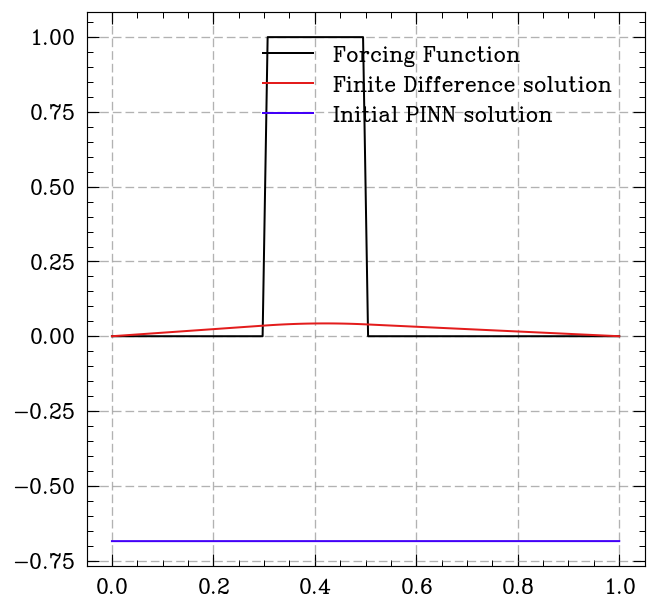

In [19]:
plt.plot(mesh_full, wrap_bc(rhs_evaluated), label="Forcing Function")
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Initial PINN solution")
plt.legend()
plt.grid()

In [20]:
def pde_residuum(network, x):
    return jax.grad(jax.grad(network))(x) + rhs_function(x)

In [21]:
pde_residuum(pinn, 0.8)

Array(-2.5913748e-06, dtype=float32)

In [22]:
key, sampling_key = jr.split(key)
collocation_points = jr.uniform(sampling_key, (N_COLLOCATION_POINTS, ), minval=0.0 + 0.001, maxval=1.0 - 0.001)

def loss_fn(network):
    pde_residuum_at_collocation_points = jax.vmap(pde_residuum, in_axes=(None, 0))(network, collocation_points)
    pde_loss_contribution = 0.5 * jnp.mean(jnp.square(pde_residuum_at_collocation_points))

    left_bc_residuum = network(0.0) - 0.0
    right_bc_residuum = network(1.0) - 0.0
    bc_residuum_contribution = 0.5 * jnp.mean(jnp.square(left_bc_residuum)) + 0.5 * jnp.mean(jnp.square(right_bc_residuum))

    total_loss = pde_loss_contribution + BC_LOSS_WEIGHT * bc_residuum_contribution

    return total_loss

In [23]:
loss_fn(pinn)

Array(47.01226, dtype=float32)

In [24]:
# Training loop
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

loss_history = []
for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 47.01226043701172
Epoch: 100, loss: 0.8580574989318848
Epoch: 200, loss: 0.08999805152416229
Epoch: 300, loss: 0.08999675512313843
Epoch: 400, loss: 0.08999650180339813
Epoch: 500, loss: 0.08999619632959366
Epoch: 600, loss: 0.0899958610534668
Epoch: 700, loss: 0.08999550342559814
Epoch: 800, loss: 0.0899951159954071
Epoch: 900, loss: 0.08999469131231308
Epoch: 1000, loss: 0.08999423682689667
Epoch: 1100, loss: 0.08999376744031906
Epoch: 1200, loss: 0.08999325335025787
Epoch: 1300, loss: 0.0899927169084549
Epoch: 1400, loss: 0.08999215066432953
Epoch: 1500, loss: 0.08999156206846237
Epoch: 1600, loss: 0.08999092876911163
Epoch: 1700, loss: 0.0899902731180191
Epoch: 1800, loss: 0.08998958021402359
Epoch: 1900, loss: 0.08998885750770569
Epoch: 2000, loss: 0.08998807519674301
Epoch: 2100, loss: 0.08998725563287735
Epoch: 2200, loss: 0.0899863913655281
Epoch: 2300, loss: 0.08998546749353409
Epoch: 2400, loss: 0.0899844840168953
Epoch: 2500, loss: 0.08998341113328934
Epoch: 

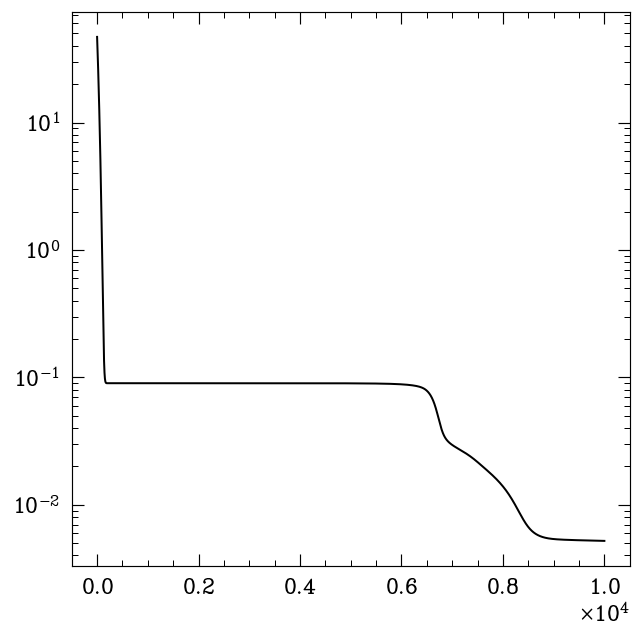

In [25]:
plt.plot(loss_history)
plt.yscale("log")

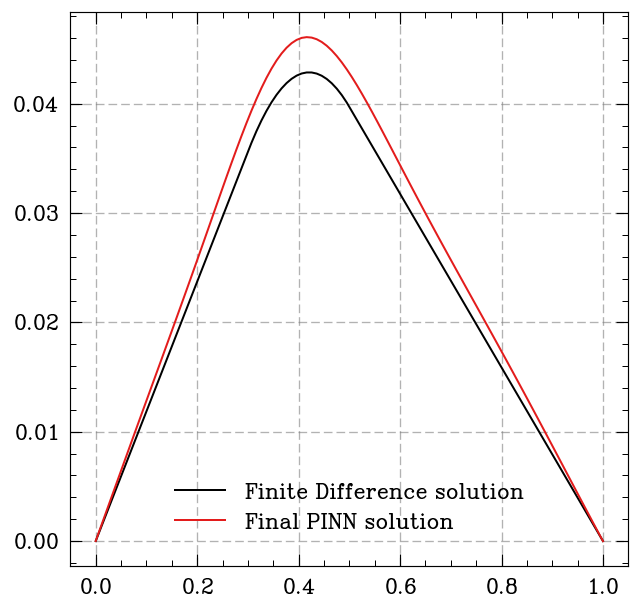

In [26]:
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Final PINN solution")
plt.legend()
plt.grid()

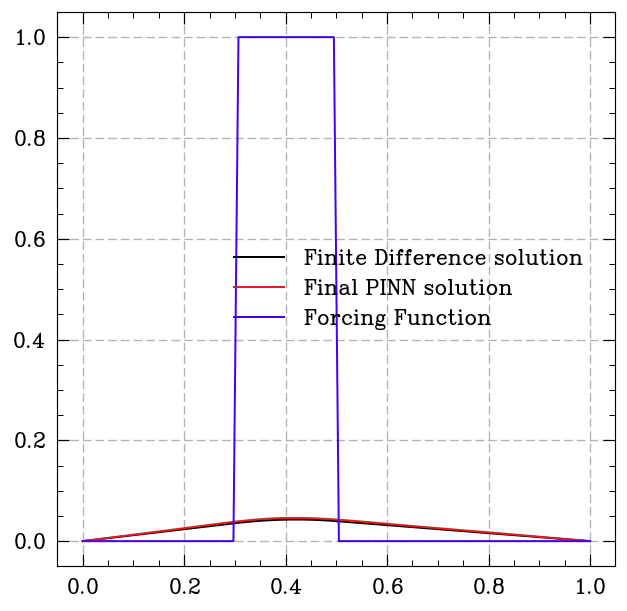

In [29]:
import matplotlib.pyplot as plt
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Final PINN solution")
plt.plot(mesh_full, wrap_bc(rhs_evaluated), label="Forcing Function")
plt.legend()
plt.grid()


In [27]:
pinn(0.33)

Array(0.04175004, dtype=float32)

In [28]:
jax.grad(pinn)(0.33)

Array(0.09535636, dtype=float32)